# 卒業研究3：カーネル関数の変更について
#### 坂西和也

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# CSVファイルを読み込む
data_path = '/home/mori/banzai/banzai_study/masuda/data.csv'
data = pd.read_csv(data_path)

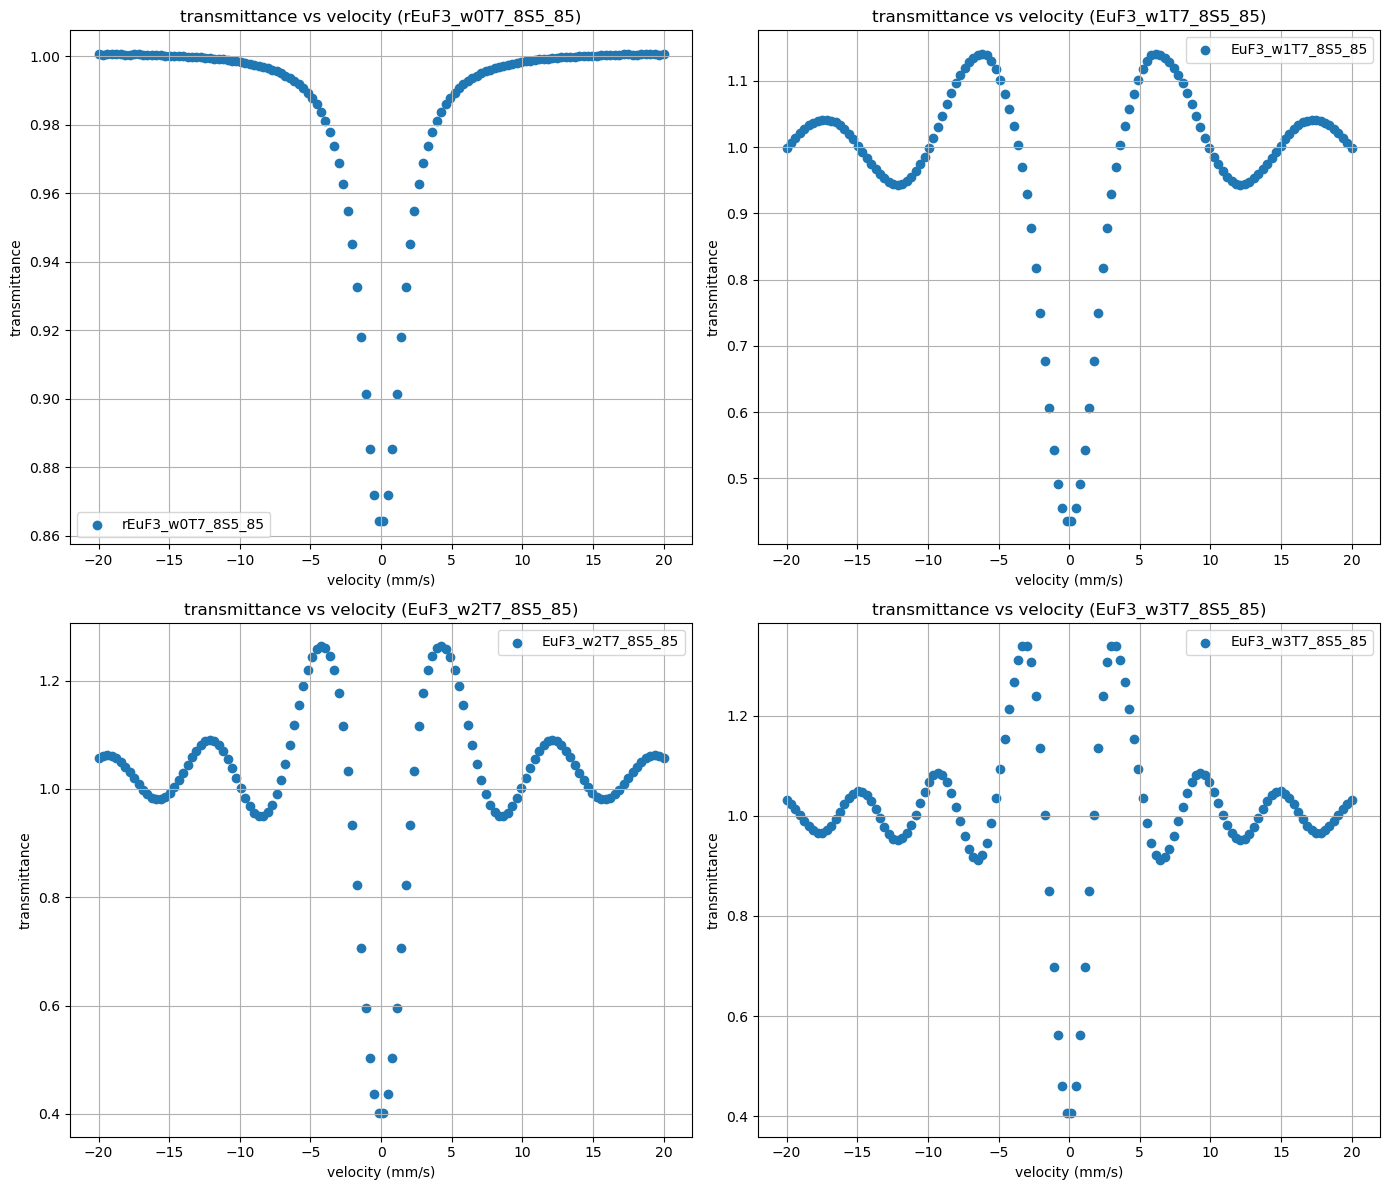

In [4]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data.columns[1:]):
    axes[idx].scatter(data['Velocity (mm/s)'], data[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [5]:
x = data['Velocity (mm/s)']
l = len(x)
print(l)

128


### ランダムノイズ付加
縦軸1.0とピークとなる値との差と同じ標準偏差とした．

1.$\sigma = 0.14$

2.$\sigma = 0.6$

In [6]:
# 正規ノイズをデータに加える

import numpy as np
import matplotlib.pyplot as plt

# データの生成
np.random.seed(0)

random0 = np.random.normal(loc = 0.0 , scale =  0.14 , size = l)
random1 = np.random.normal(loc = 0.0 , scale =  0.60 , size = l)

data = pd.read_csv(data_path)

y1 = data['rEuF3_w0T7_8S5_85'] + random0
y2 = data['EuF3_w1T7_8S5_85'] + random1
y3 = data['EuF3_w2T7_8S5_85'] + random1
y4 = data['EuF3_w3T7_8S5_85'] + random1

In [7]:
import pandas as pd

data_add_error = pd.DataFrame({
    'Velocity (mm/s)'   : x,
    'rEuF3_w0T7_8S5_85' : y1,
    'EuF3_w1T7_8S5_85'  : y2,
    'EuF3_w2T7_8S5_85'  : y3,
    'EuF3_w3T7_8S5_85'  : y4,
})

In [8]:
data_add_error.to_csv('data_add_error.csv', index=False)

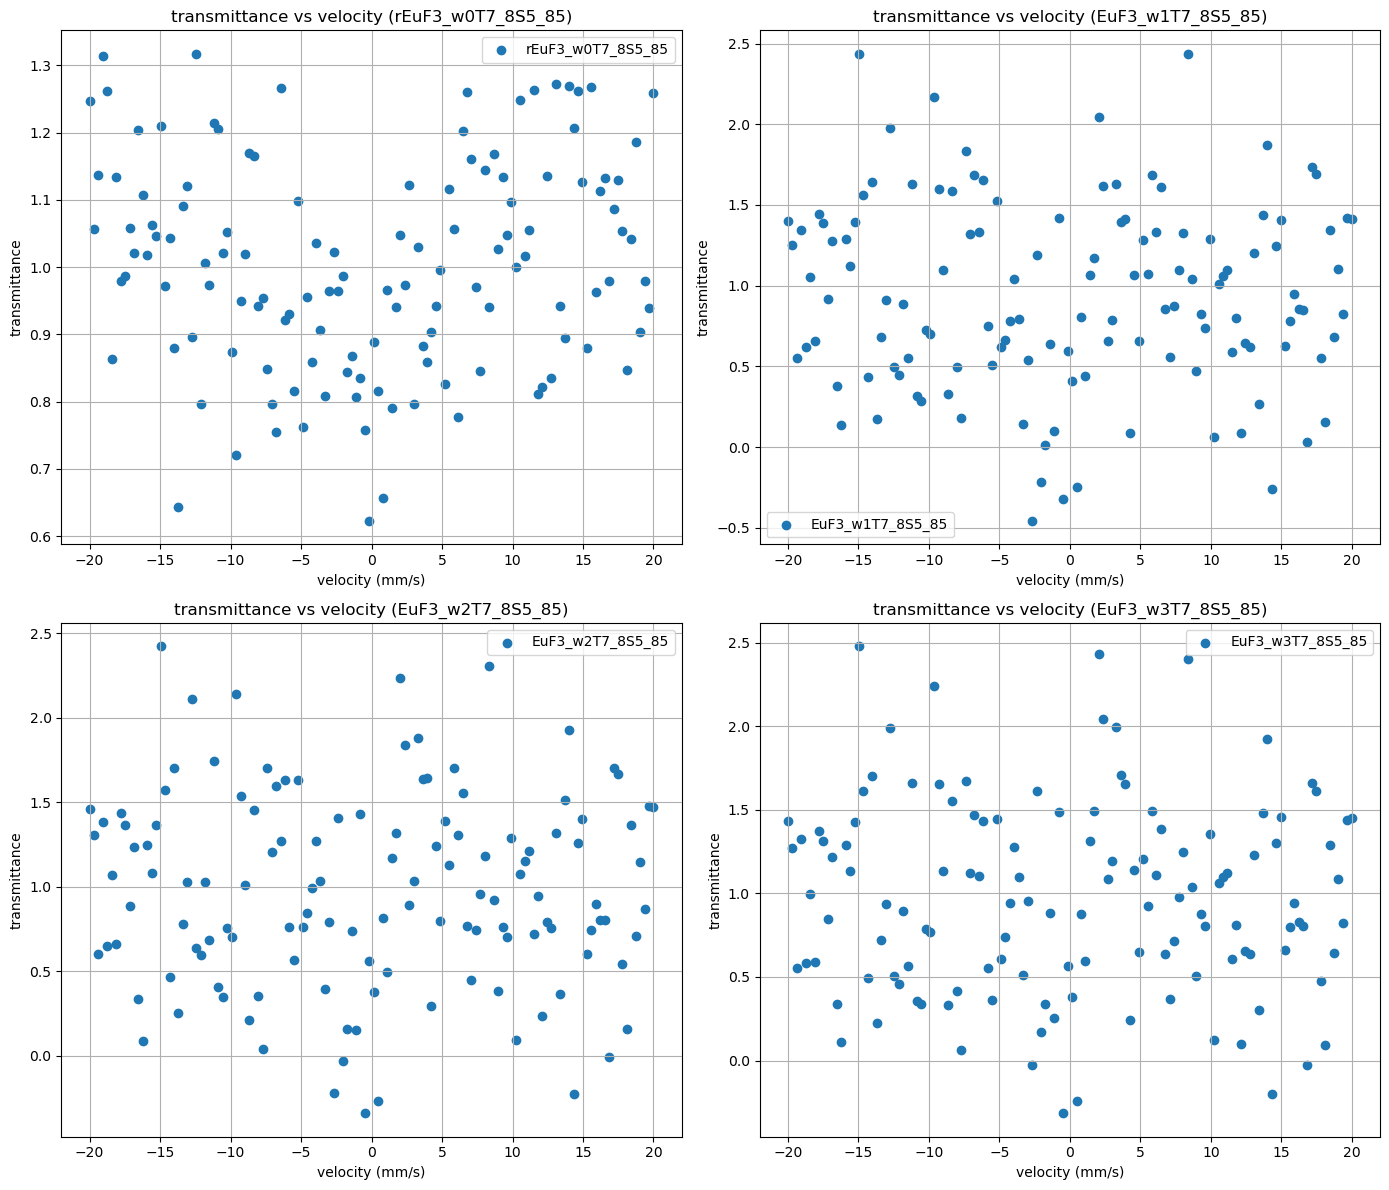

In [9]:
# 2列から5列までのデータをそれぞれ散布図でプロット
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.ravel()

for idx, column in enumerate(data_add_error.columns[1:]):
    axes[idx].scatter(data_add_error['Velocity (mm/s)'], data_add_error[column], label=column)
    axes[idx].set_title(f'transmittance vs velocity ({column})')
    axes[idx].set_xlabel('velocity (mm/s)')
    axes[idx].set_ylabel('transmittance')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

## ガウス過程回帰で再現

### RBFカーネル
$$
k(x , x^{\prime}) =\sigma^2 \exp \left( - \frac{|| x - x^{\prime} || ^2}{2 l^2}  \right)
$$

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004  -2.110328e+01   9.186083e+02 
    00s01  0006  -3.930061e+01   2.839914e+01 
    00s02  0014  -5.729667e+01   2.274635e-04 
    00s03  0020  -5.729686e+01   2.787870e-13 
    00s03  0021  -5.729686e+01   2.787870e-13 
Runtime:     00s03
Optimization status: Converged



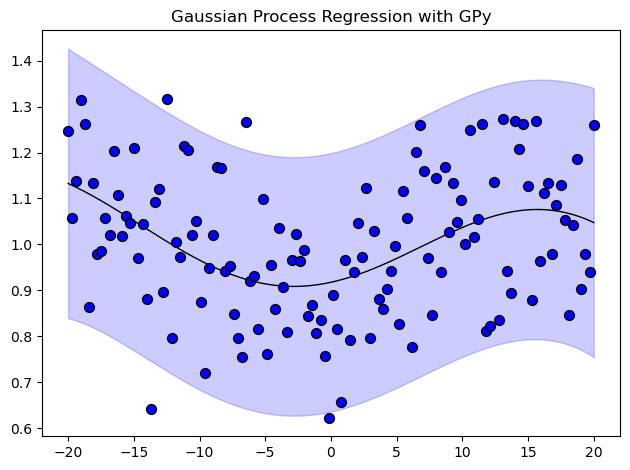

In [10]:
# rEuF3_w0T7_8S5_85
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy")
plt.tight_layout()
plt.show()

#### ハイパーパラメータ

In [11]:
# カーネルの分散 (σ^2)
variance = model.kern.variance[0]

# カーネルの長さスケール (l)
lengthscale = model.kern.lengthscale[0]

variance, lengthscale

(0.7025729554324238, 21.4228317851001)

## 指数カーネル
$$
k(x , x^{\prime}) =\sigma^2 \exp \left( - \frac{|| x - x^{\prime} || }{ l}  \right)
$$

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0008  -2.100881e+01   2.859560e+01 
    00s02  0015  -4.930386e+01   1.526250e+01 
    00s04  0028  -5.937921e+01   6.405268e-02 
    00s06  0037  -5.947778e+01   7.659100e-05 
    00s06  0039  -5.947779e+01   3.006507e-09 
    00s07  0040  -5.947779e+01   3.006507e-09 
Runtime:     00s07
Optimization status: Converged



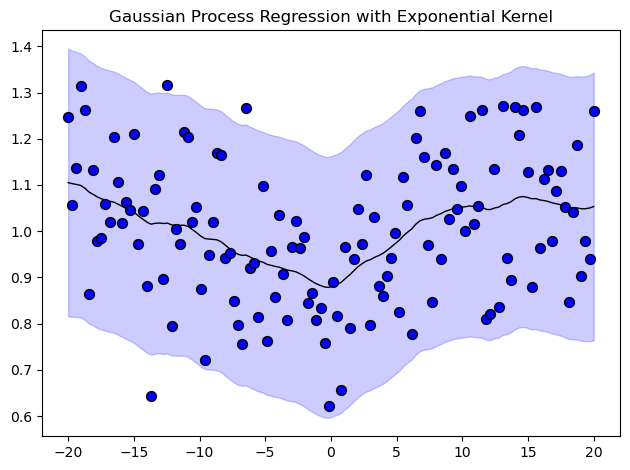

In [12]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# 指数カーネルを使用したガウス過程モデルの定義
kernel = GPy.kern.Exponential(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Exponential Kernel")
plt.tight_layout()
plt.show()


### ハイパーパラメータ

In [13]:
# カーネルの分散 (σ^2)
variance = model.kern.variance[0]

# カーネルの長さスケール (l)
lengthscale = model.kern.lengthscale[0]

variance, lengthscale

(1.1650989506988454, 2228.6274466181535)

## 周期カーネル

$$
k(x , x^{\prime}) =\exp \left( \theta_1 \cos\left( \frac{|x - x^{\prime}|}{\theta_2} \right) \right)
$$

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   8.923695e+01   2.046833e+03 
    00s01  0007  -3.192147e+01   9.224469e+01 
    00s02  0012  -3.499212e+01   4.983188e+01 
    00s04  0030  -3.501530e+01   9.005555e+00 
Runtime:     00s04
Optimization status: Converged

Custom Periodic kernel parameters:
Theta_1: 0.8951022578052326
Theta_2: 1.0487862277159556


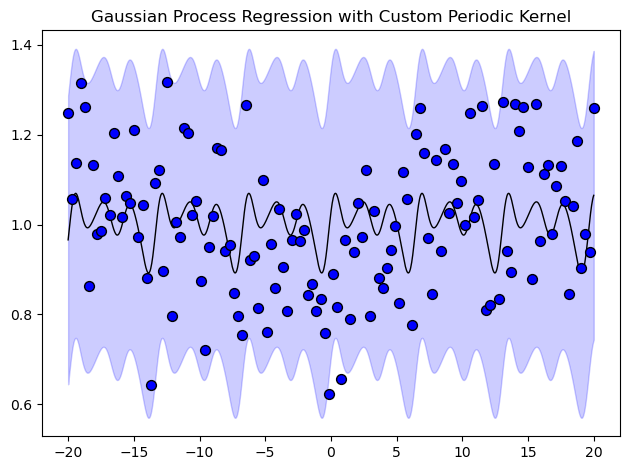

In [14]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# カスタムの周期カーネルを定義
class CustomPeriodicKernel(GPy.kern.Kern):
    def __init__(self, input_dim, theta_1=1.0, theta_2=1.0, active_dims=None):
        super(CustomPeriodicKernel, self).__init__(input_dim, active_dims, 'custom_periodic')
        self.theta_1 = GPy.Param('theta_1', theta_1)
        self.theta_2 = GPy.Param('theta_2', theta_2)
        self.link_parameters(self.theta_1, self.theta_2)
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        return np.exp(self.theta_1 * np.cos(dist / self.theta_2))

    def Kdiag(self, X):
        return np.exp(self.theta_1) * np.ones(X.shape[0])

    def update_gradients_full(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        
        dK_dtheta1 = np.cos(dist / self.theta_2)
        dK_dtheta2 = self.theta_1 * np.sin(dist / self.theta_2) * dist / (self.theta_2**2)
        
        self.theta_1.gradient = np.sum(dL_dK * dK_dtheta1)
        self.theta_2.gradient = np.sum(dL_dK * dK_dtheta2)

# カーネルのインスタンスを作成
kernel = CustomPeriodicKernel(input_dim=1)

# ガウス過程モデルの定義
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# ハイパーパラメータの値を表示
print("Custom Periodic kernel parameters:")
print(f"Theta_1: {model.kern.theta_1[0]}")
print(f"Theta_2: {model.kern.theta_2[0]}")

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Custom Periodic Kernel")
plt.tight_layout()
plt.show()


## カーネルの組み合わせ

### RBF + 指数

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.664358e+02           nan 
    00s01  0005   1.429674e+01   8.545442e+02 
    00s03  0012  -4.068873e+01   1.681589e+02 
    00s03  0015  -5.587014e+01   1.539703e+01 
    00s06  0030  -5.751641e+01   1.151872e-01 
    00s12  0060  -5.947644e+01   6.709888e-03 
    00s14  0072  -5.948052e+01   1.319639e-05 
    00s15  0076  -5.948052e+01   4.691451e-09 


Runtime:     00s15
Optimization status: Converged

RBF kernel parameters:
Variance (σ^2): 0.7237466065051844
Lengthscale (l): 1766.164739911418

Exponential kernel parameters:
Variance (σ^2): 0.43463098169891107
Lengthscale (l): 830.3235633381057


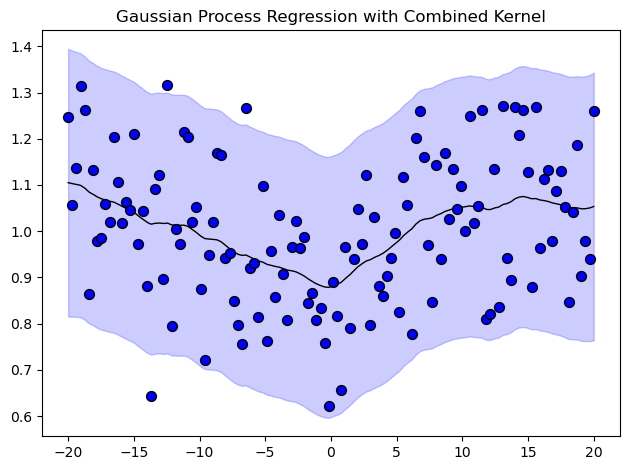

In [18]:
import GPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# 2. RBFカーネルと指数カーネルの定義
kernel_rbf = GPy.kern.RBF(input_dim=1, name="rbf")
kernel_exponential = GPy.kern.Exponential(input_dim=1, name="exponential")

# 3. カーネルを組み合わせる
kernel_combined = kernel_rbf + kernel_exponential

# 4. ガウス過程モデルの定義
model = GPy.models.GPRegression(X, y, kernel_combined)

# 5. モデルの最適化
model.optimize(messages=True)

# 6. ハイパーパラメータの値を表示
print("RBF kernel parameters:")
print(f"Variance (σ^2): {model.kern.rbf.variance[0]}")
print(f"Lengthscale (l): {model.kern.rbf.lengthscale[0]}")
print("\nExponential kernel parameters:")
print(f"Variance (σ^2): {model.kern.exponential.variance[0]}")
print(f"Lengthscale (l): {model.kern.exponential.lengthscale[0]}")

# 予測とプロット
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Combined Kernel")
plt.tight_layout()
plt.show()

比較

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.610135e+02           nan 

    00s00  0001   1.610135e+02   8.271757e+02 
    00s00  0005   1.672942e+03   2.334815e+06 
    00s00  0007  -1.659205e+01   4.862992e+01 
    00s01  0015  -4.930386e+01   1.526250e+01 
    00s03  0029  -5.943577e+01   3.578853e-03 
    00s04  0036  -5.947768e+01   3.206145e-03 
    00s04  0040  -5.947779e+01   3.006507e-09 
Runtime:     00s04
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   1.361910e+02   1.034108e+03 
    00s01  0007  -1.417830e+01   1.145457e+02 
    00s02  0015  -5.587014e+01   1.539703e+01 
    00s03  0018  -5.731216e+01   9.856446e-01 
    00s10  0052  -5.935894e+01   1.844471e-01 
    00s11  0061  -5.947824e+01   9.775441e-04 
    00s13  0068  -5.947465e+01   1.739806e-01 
    00s14  0076  -5.948052e+01   4.689152e-09 
Runtime:     00s14
Optimization status: Converged

Exponential kernel parameters:
Variance (σ^2): 1.1650989506955276
Lengthscale (l): 2228.627446611834


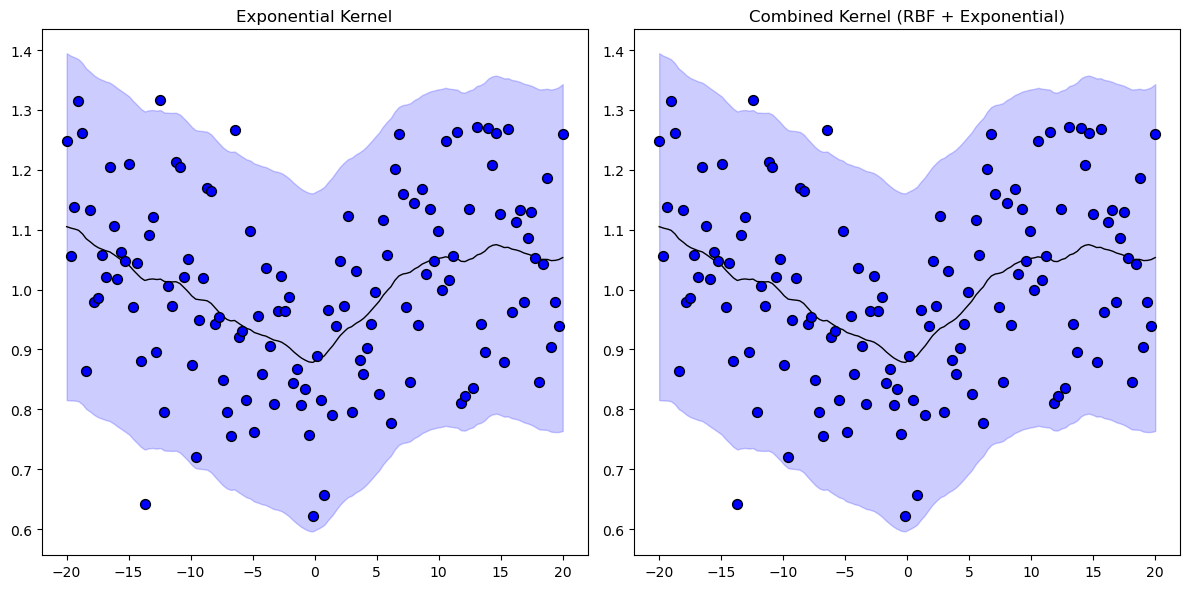

In [20]:
import GPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# 2. RBFカーネル、指数カーネル、および組み合わせカーネルを定義
kernel_rbf = GPy.kern.RBF(input_dim=1, name="rbf")
kernel_exponential = GPy.kern.Exponential(input_dim=1, name="exponential")
kernel_combined = kernel_rbf + kernel_exponential

# 3. ガウス過程回帰モデルを定義
model_exp = GPy.models.GPRegression(X, y, kernel_exponential)
model_combined = GPy.models.GPRegression(X, y, kernel_combined)

# 4. モデルを最適化
model_exp.optimize(messages=True)
model_combined.optimize(messages=True)

# 5. ハイパーパラメータの値を表示
print("Exponential kernel parameters:")
print(f"Variance (σ^2): {model_exp.kern.variance[0]}")
print(f"Lengthscale (l): {model_exp.kern.lengthscale[0]}")
print("\nCombined kernel (RBF + Exponential) parameters:")
print(f"RBF Variance (σ^2): {model_combined.kern.rbf.variance[0]}")
print(f"RBF Lengthscale (l): {model_combined.kern.rbf.lengthscale[0]}")
print(f"Exponential Variance (σ^2): {model_combined.kern.exponential.variance[0]}")
print(f"Exponential Lengthscale (l): {model_combined.kern.exponential.lengthscale[0]}")

# 6. 予測とプロット
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred_exp, var_pred_exp = model_exp.predict(X_pred)
y_pred_combined, var_pred_combined = model_combined.predict(X_pred)

plt.figure(figsize=(12, 6))

# Exponential kernel plot
plt.subplot(1, 2, 1)
plt.plot(X_pred, y_pred_exp, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred_exp.ravel() - 1.96*np.sqrt(var_pred_exp).ravel(), y_pred_exp.ravel() + 1.96*np.sqrt(var_pred_exp).ravel(), alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Exponential Kernel")

# Combined kernel plot
plt.subplot(1, 2, 2)
plt.plot(X_pred, y_pred_combined, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred_combined.ravel() - 1.96*np.sqrt(var_pred_combined).ravel(), y_pred_combined.ravel() + 1.96*np.sqrt(var_pred_combined).ravel(), alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Combined Kernel (RBF + Exponential)")

plt.tight_layout()
plt.show()

### RBF + 指数 + 周期

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   6.514945e+01   1.499507e+03 
    00s03  0008   6.586240e+01   8.536717e+04 
    00s05  0016  -2.112554e+01   1.789281e+02 
    00s08  0025  -2.306529e+01   2.828657e+01 
    00s17  0053  -5.562031e+01   5.453666e+01 

    00s19  0061  -5.661906e+01   1.508812e+00 
    00s42  0138  -5.919967e+01   3.153585e-06 
Runtime:     00s42
Optimization status: Converged

RBF kernel parameters:
Variance (σ^2): 0.637553031901126
Lengthscale (l): 19.70166963189318

Exponential kernel parameters:
Variance (σ^2): 0.01762432489395187
Lengthscale (l): 0.00029130934692656274

Periodic kernel parameters:
Variance (σ^2): 0.04258272235333211
Lengthscale (l): 0.015913892155093534
Period (p): 8.544840474498955


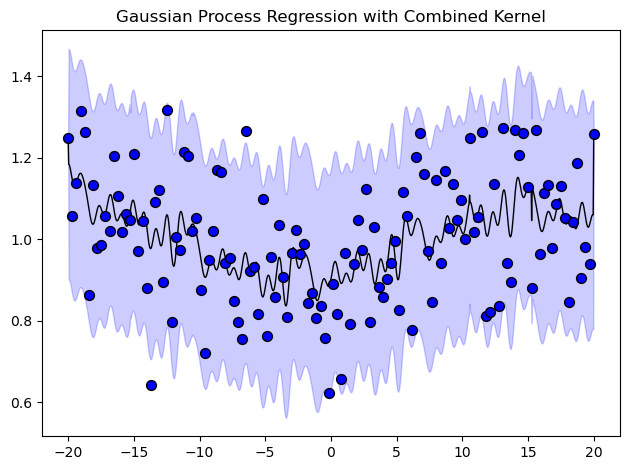

In [16]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt


# 各カーネルの定義
kernel_rbf = GPy.kern.RBF(input_dim=1, name="rbf")
kernel_exponential = GPy.kern.Exponential(input_dim=1, name="exponential")
kernel_periodic = GPy.kern.PeriodicExponential(input_dim=1, name="periodic")

# カーネルを組み合わせる
kernel_combined = kernel_rbf + kernel_exponential + kernel_periodic

# ガウス過程モデルの定義
model = GPy.models.GPRegression(X, y, kernel_combined)

# ジッターの追加
model.Gaussian_noise.variance.constrain_fixed(1e-5)

# モデルの最適化
model.optimize(messages=True)

# ハイパーパラメータの値を表示
print("RBF kernel parameters:")
print(f"Variance (σ^2): {model.kern.rbf.variance[0]}")
print(f"Lengthscale (l): {model.kern.rbf.lengthscale[0]}")
print("\nExponential kernel parameters:")
print(f"Variance (σ^2): {model.kern.exponential.variance[0]}")
print(f"Lengthscale (l): {model.kern.exponential.lengthscale[0]}")
print("\nPeriodic kernel parameters:")
print(f"Variance (σ^2): {model.kern.periodic.variance[0]}")
print(f"Lengthscale (l): {model.kern.periodic.lengthscale[0]}")
print(f"Period (p): {model.kern.periodic.period[0]}")

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Combined Kernel")
plt.tight_layout()
plt.show()


## 他のデータでもやってみる

### 周期

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007   1.215693e+02   6.727858e+02 
    00s02  0013   1.206544e+02   1.732252e+02 

    00s03  0022   1.113913e+02   2.125101e+01 
    00s03  0023   1.113913e+02   2.125101e+01 
Runtime:     00s03
Optimization status: Converged

Custom Periodic kernel parameters:
Theta 1: 0.37966919387326403
Theta 2: 0.9264038021071397


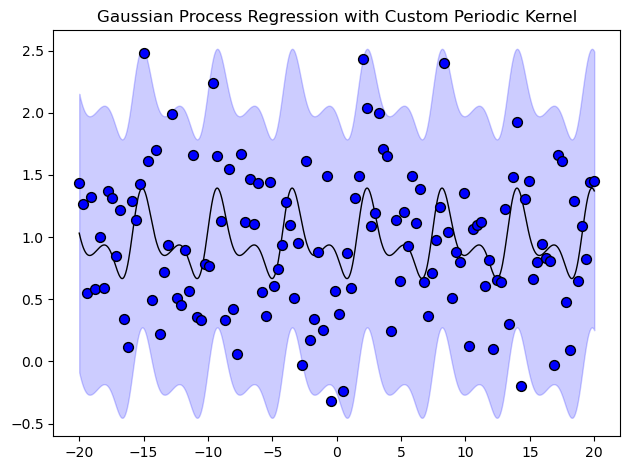

In [26]:
import GPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data["EuF3_w3T7_8S5_85"].values.reshape(-1, 1)

# 2. カスタムの周期カーネルの定義
class CustomPeriodicKernel(GPy.kern.Kern):
    def __init__(self, input_dim, theta_1=1.0, theta_2=1.0, active_dims=None):
        super(CustomPeriodicKernel, self).__init__(input_dim, active_dims, 'custom_periodic')
        self.theta_1 = GPy.Param('theta_1', theta_1)
        self.theta_2 = GPy.Param('theta_2', theta_2)
        self.link_parameters(self.theta_1, self.theta_2)
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        return np.exp(self.theta_1 * np.cos(dist / self.theta_2))

    def Kdiag(self, X):
        return np.exp(self.theta_1) * np.ones(X.shape[0])

    def update_gradients_full(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        
        dK_dtheta1 = np.cos(dist / self.theta_2)
        dK_dtheta2 = self.theta_1 * np.sin(dist / self.theta_2) * dist / (self.theta_2**2)
        
        self.theta_1.gradient = np.sum(dL_dK * dK_dtheta1)
        self.theta_2.gradient = np.sum(dL_dK * dK_dtheta2)

# 3. ガウス過程回帰モデルの定義
kernel = CustomPeriodicKernel(input_dim=1)
model = GPy.models.GPRegression(X, y, kernel)

# 4. モデルの最適化
model.optimize(messages=True)

# 5. ハイパーパラメータの値を表示
print("Custom Periodic kernel parameters:")
print(f"Theta 1: {model.kern.theta_1[0]}")
print(f"Theta 2: {model.kern.theta_2[0]}")

# 6. 予測とプロット
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Custom Periodic Kernel")
plt.tight_layout()
plt.show()


### RBF + 周期

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   1.481749e+02   2.383679e+03 
    00s02  0011   1.155380e+02   1.507945e+02 


Runtime:     00s02
Optimization status: Converged

RBF kernel parameters:
Variance (σ^2): 0.009480442238309026
Lengthscale (l): 1.5475529319953898

Custom Periodic kernel parameters:
Theta 1: 0.1478792390068534
Theta 2: 1.8090965431492976


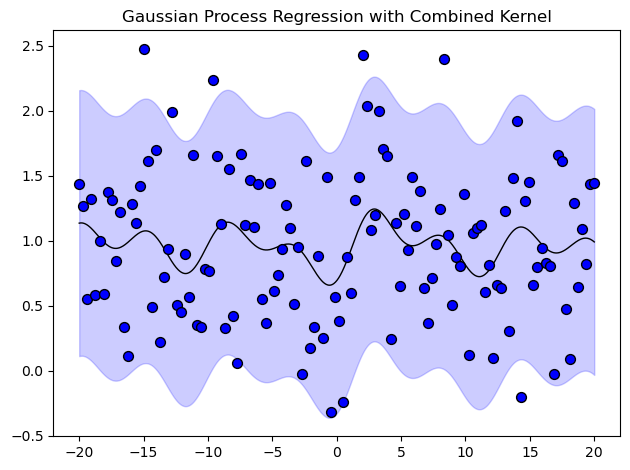

In [28]:
import GPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. データの読み込み
data = pd.read_csv('/home/mori/banzai/banzai_study/masuda/data_add_error.csv')
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data["EuF3_w3T7_8S5_85"].values.reshape(-1, 1)

# 2. RBFカーネルの定義
kernel_rbf = GPy.kern.RBF(input_dim=1)


# 4. カーネルの組み合わせ (加算)
kernel_combined = kernel_rbf + CustomPeriodicKernel(input_dim=1)

# 5. ガウス過程回帰モデルの定義
model = GPy.models.GPRegression(X, y, kernel_combined)

# 6. モデルの最適化
model.optimize(messages=True)

# 7. 各カーネルのハイパーパラメータの値を表示
print("RBF kernel parameters:")
print(f"Variance (σ^2): {model.kern.rbf.variance[0]}")
print(f"Lengthscale (l): {model.kern.rbf.lengthscale[0]}")

print("\nCustom Periodic kernel parameters:")data = pd.read_csv('/path/to/your/data.csv')
print(f"Theta 1: {model.kern.custom_periodic.theta_1[0]}")
print(f"Theta 2: {model.kern.custom_periodic.theta_2[0]}")

# 8. 予測とプロット
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Combined Kernel")
plt.tight_layout()
plt.show()